# Gene GNN: Embedding Visualization

**Goal:** Analyze the gene embeddings learned by the GeneGNN model.

**Data:** Gene-Gene Co-expression Graph
**Model:** GeneGNN (Graph Convolutional Network)

## Key Analyses
1. **Load Data & Model**: Load the processed gene graph and trained checkpoint.
2. **Generate Embeddings**: Extract latent representations for all genes.
3. **Visualization**: UMAP of gene embeddings to identify clusters of co-regulated genes.

In [1]:
import torch
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add src to path
sys.path.append(os.path.abspath('../src'))
from models.gnn_models import GeneGNN

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 8)

### 1. Load Gene Graph Data

In [2]:
data_path = '../data/processed/graphs/gene_graph.pt'
if not os.path.exists(data_path):
    print(f"Error: File not found at {data_path}")
else:
    # Set weights_only=False to allow loading PyG Data objects if needed, 
    # ideally we should use weights_only=True and allowlist
    try:
        data = torch.load(data_path)
    except Exception as e:
        print(f"Loading failed, trying without weights_only check (unsafe): {e}")
        data = torch.load(data_path, weights_only=False)
        
    print(f"Loaded Gene graph: {data}")

Loaded Gene graph: Data(x=[2000, 2], edge_index=[2, 499132], edge_attr=[499132], gene_names=[2000])


C:\Users\thoma\AppData\Local\Temp\ipykernel_20200\2654759366.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)


### 2. Load Trained Model

In [3]:
ckpt_path = '../outputs/gene_model.ckpt'

if os.path.exists(ckpt_path):
    print(f"Loading model from {ckpt_path}...")
    # Initialize model with correct dimensions
    # GeneGNN(in_channels, hidden_channels, out_channels)
    # Hidden and out dims must match training args (default: 64, 32)
    in_channels = data.x.shape[1]
    hidden_channels = 64
    out_channels = 32
    
    model = GeneGNN(in_channels, hidden_channels, out_channels)
    
    try:
        checkpoint = torch.load(ckpt_path, weights_only=False)
        state_dict = {k.replace('model.', ''): v for k, v in checkpoint['state_dict'].items()}
        model.load_state_dict(state_dict)
        print("Model loaded successfully.")
    except Exception as e:
        print(f"Failed to load checkpoint: {e}")
        
    model.eval()
else:
    print("Checkpoint not found. Run training script first: python scripts/train.py --model gene ...")

Loading model from ../outputs/gene_model.ckpt...
Model loaded successfully.


### 3. Generate and Visualize Embeddings

Generated embeddings shape: (2000, 32)
Computing UMAP...


c:\Users\thoma\miniconda3\envs\brain-gnn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Plotting Gene Embeddings...


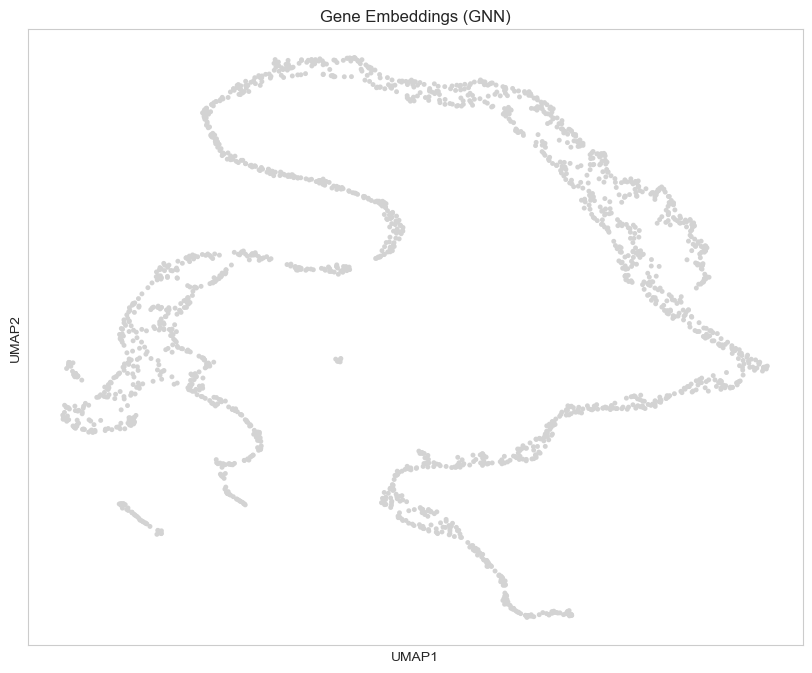

In [4]:
if 'model' in locals():
    with torch.no_grad():
        embeddings = model(data.x, data.edge_index).numpy()
    print(f"Generated embeddings shape: {embeddings.shape}")
    
    # Use Scanpy for easy UMAP plotting
    adata_emb = sc.AnnData(X=embeddings)
    
    # Compute neighbors and UMAP on embeddings
    print("Computing UMAP...")
    sc.pp.neighbors(adata_emb, use_rep='X')
    sc.tl.umap(adata_emb)
    
    # Plot
    print("Plotting Gene Embeddings...")
    sc.pl.umap(adata_emb, title='Gene Embeddings (GNN)', s=50)
else:
    print("Model not loaded.")